# Driverless AI: Comparing Model Families

This notebook walks through how to build experiments using only certain families of algorithms and then comparing them. This would allow for understanding the trade off of algorithm complexity vs. the accuracy of the final model.

## Before We Begin:

* This notebook uses the backend python client which you can download from the `RESOURCES` section of the UI menu
* This notebook has been written and tested in 1.8.2, other versions of DAI may need modifications to the function parameters
* Python 3.6 is required
* You can use `Shift+Tab` to the see the signature and docstring of any function while using Jupyter

In [1]:
import pandas as pd # local data manipulation
import matplotlib.pyplot as plt # plot results
import getpass # keep password out of the notebook
from h2oai_client import Client # connect to DAI

%matplotlib inline

## Connect to Driverless AI
* Create a connection object for interacting with DAI 
* Print and login to the GUI

<br/> **Note:** Click the DAI URL and log in now as you have the password saved to save time later in this notebook

In [2]:
address = 'http://18.212.25.119:12345'
username = 'h2oai'

dai = Client(address = address, 
             username = username, 
             password = getpass.getpass("Enter your Driverless AI password: "))

Enter your Driverless AI password: ········


In [3]:
print(dai.address)

http://18.212.25.119:12345


## Create a Project
* Create a project for visually comparing the algorithm family performances

In [4]:
project_key = dai.create_project("Telco Churn", "Understand accuracy by model family")

## Load a Dataset
Most DAI instances come with some sample data in the `data` folder on the server. We will load in a dataset about customers who may churn from a telco.

* Load a dataset from the DAI server
* Print columns in the dataset
* Create a variables to use in modeling
* Look at the distribution of the target column
* Add the dataset to the project

In [5]:
telco_data = dai.create_dataset_sync('/data/Splunk/churn.csv')

In [6]:
[c.name for c in telco_data.columns]

['State',
 'Account Length',
 'Area Code',
 'Phone',
 "Int'l Plan",
 'VMail Plan',
 'VMail Message',
 'Day Mins',
 'Day Calls',
 'Day Charge',
 'Eve Mins',
 'Eve Calls',
 'Eve Charge',
 'Night Mins',
 'Night Calls',
 'Night Charge',
 'Intl Mins',
 'Intl Calls',
 'Intl Charge',
 'CustServ Calls',
 'Churn?']

In [7]:
# Informatin to use in modeling
col_y = "Churn?"
scoring_metric = "AUC"

In [8]:
for c in telco_data.columns:
    if c.name == col_y:
        print(c.stats.non_numeric.hist_ticks)
        print(c.stats.non_numeric.hist_counts)

['False.', 'True.']
[2850, 483]


In [9]:
dai.link_dataset_to_project(project_key = project_key, 
                            dataset_key = telco_data.key, 
                            dataset_type = "Training")

## Run Experiments
* List all algorithms available on the system
* Create a dictionary of model families
* Run an experiment for each model family

In [10]:
[m.name for m in dai.list_model_estimators()]

['DECISIONTREE',
 'FTRL',
 'GLM',
 'IMBALANCEDLIGHTGBM',
 'IMBALANCEDXGBOOSTGBM',
 'LIGHTGBM',
 'RULEFIT',
 'TENSORFLOW',
 'XGBOOSTDART',
 'XGBOOSTGBM']

In [11]:
model_families = [{"name": "Regression", "models": ['GLM'], "complexity": 0},
                  {"name": "Decision Tree", "models": ['DECISIONTREE'], "complexity": 1},
                  {"name": "Boosting Trees", "models": ['LIGHTGBM', 'XGBOOSTDART', 'XGBOOSTGBM'], "complexity": 2},
                  {"name": "Neural Net", "models": ['TENSORFLOW'], "complexity": 3}
                 ]

In [12]:
results = pd.DataFrame()

for m in model_families:
    # Run the experiment
    experiment = dai.start_experiment_sync(experiment_name=m["name"],
                                           dataset_key=telco_data.key,
                                           testset_key = '',
                                           target_col=col_y,
                                           is_classification=True,
                                           accuracy=1, time=1, interpretability=6,
                                           scorer="AUC",
                                           config_overrides="included_models=" + str(m["models"]) 
                                          )

    # add to our project
    dai.link_experiment_to_project(project_key = project_key, 
                                   experiment_key = experiment.key)

    # add validation results to our dataframee
    exp_results = pd.DataFrame([{'name': m["name"],
                                 'complexity': m["complexity"], 
                                 'validation_score': experiment.valid_score,
                                 'test_score': experiment.test_score,
                                 'experiment_id': experiment.key}])

    results = pd.concat([results, exp_results], axis = 0)

## View Results
* View resulting table
* View plot of accuracy by model family
* Link to UI for Project comparison

In [13]:
results

,complexity,experiment_id,name,test_score,validation_score
0,0,d732a2c6-5d89-11ea-82fd-0242ac110002,Regression,None,0.850078
0,1,feef1e3e-5d89-11ea-82fd-0242ac110002,Decision Tree,None,0.875228
0,2,22d2bab8-5d8a-11ea-82fd-0242ac110002,Boosting Trees,None,0.918603
0,3,4cde3094-5d8a-11ea-82fd-0242ac110002,Neural Net,None,0.835971


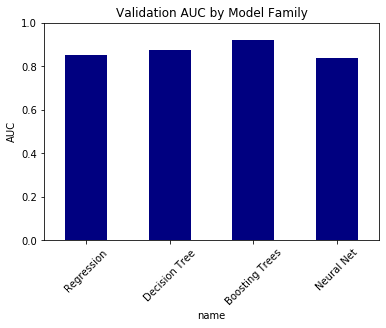

In [14]:
results.plot(x="name", 
             y="validation_score", 
             kind="bar",
             title="Validation AUC by Model Family",
             legend=False,
             colormap='jet',
             ylim=(0,1))

plt.xticks(rotation=45 )
plt.ylabel('AUC')
plt.show()

In [15]:
print(dai.address + "/#project?key=" + project_key)

http://18.212.25.119:12345/#project?key=d58a5414-5d89-11ea-82fd-0242ac110002
